

# Bipedal gait bio-mimicry using a foldable mechanism
## FInal Project, RAS 557: Foldable Robotics
#### Jahnav Rokalaboina, Nihar Masurkar, Kunal Nitin Palasdeokar


## Simulation study:

In [1]:
## Import all necessary libraries

import os
import mujoco
import math
import numpy
import mediapy as media
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#### Establishing the xml template for bipedal mechanism

1. Bipedal robot is supported by a beam like structure which supports the robot from falling and a defined prismatic joint helps in moving along the beam
2. Template takes in two variables, support beam structure height to evaluate the static and dynamic performance of gait cycle and end effector link length to evaluate the gait of the robot at a set support structure height
3. A small sphere is attached at the end of end-effector which helps in tracking the position of the end effector
4. Servo motors are defined accordingly to control the two joints of each five bar mechanism

In [2]:
xml_template = '''
<mujoco>
    <option timestep ="1e-4"/>
    <option><flag gravity = "enable" contact="enable" /></option>
    <compiler angle="degree" />
         <visual><global offwidth="800" offheight="600"/></visual>
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <camera name="world" mode="fixed" pos="0 -0.5 0.2" axisangle="1 0 0 80" />
        <body name="floor" pos="0 0 0">
            <geom name="floor" pos="0 0 0" size="1 1 .001" type="plane" rgba="1 0.83 0.61 0.5"/>
        </body>

        <body name="support" pos="{support_pos}">
            <joint name="slider" type="slide" pos="0 0 0" axis="1 0 0" damping="0.01"/>
            <geom type="box" size="1 0.01 0.001" pos="0 0 0" rgba="0 1 1 1" mass="0.01"/>
            <body name="Body" pos= "0 0 0.001" axisangle="0 1 0 0">
                <geom type="box" size="0.06 0.04 0.0005" pos="0 0 0" rgba="1 0 0 1"/>
                <body name="Base A" pos= "0 -0.05 0" axisangle="0 1 0 0">
                    <geom type="box" size="0.02 0.01 0.0005" pos="0 0 0" rgba="0 1 0 1"/>
                    <body name="L1_A" pos= "0.02 0 0">
                        <joint name="J1_A" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                        <geom type="box" size="0.02 0.01 0.0005" pos="0.02 0 0" rgba="0 0 1 1" mass="0.1"/>
                        <body name="L2_A" pos= "0.04 0 0">
                            <joint name="J2_A" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                            <geom type="box" size="0.025 0.01 0.0005" pos="0.025 0 0" rgba="0 0 1 1" mass="0.1"/>
                            <body name="con_A" pos= "0.05 0 0">
                                <joint name="J5_A" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                                <geom type="box" size="0.025 0.01 0.0005" pos="0.025 0 0" rgba="0 0 1 1" mass="0.1"/>
                            </body>
                        </body>
                    </body>
                    <body name="L3_A" pos= "-0.02 0 0">
                        <joint name="J3_A" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                        <geom type="box" size="0.02 0.01 0.0005" pos="-0.02 0 0" rgba="0 0 1 1" mass="0.1"/>
                        <body name="L4_A" pos= "-0.04 0 0">
                            <joint name="J4_A" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                            <geom type="box" size="{link4}" pos="{pos4}" rgba="0 0 1 1" mass="0.1"/>
                            <body name="foot_A" pos="{foot_pos}">
                                <geom type="sphere" size="0.0002" pos="-0.0002 0 0" rgba="1 0 0 1" mass="0.001"/>
                            </body>
                        </body>
                    </body>
                </body>  
                
                <body name="Base B" pos= "0 0.05 0" axisangle="0 1 0 0">
                    <geom type="box" size="0.02 0.01 0.0005" pos="0 0 0" rgba="0 1 0 1"/>
                    <body name="L1_B" pos= "0.02 0 0">
                        <joint name="J1_B" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                        <geom type="box" size="0.02 0.01 0.0005" pos="0.02 0 0" rgba="0 0 1 1" mass="0.1"/>
                        <body name="L2_B" pos= "0.04 0 0">
                            <joint name="J2_B" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                            <geom type="box" size="0.025 0.01 0.0005" pos="0.025 0 0" rgba="0 0 1 1" mass="0.1"/>
                            <body name="con_B" pos= "0.05 0 0">
                                <joint name="J5_B" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                                <geom type="box" size="0.025 0.01 0.0005" pos="0.025 0 0" rgba="0 0 1 1" mass="0.1"/>
                            </body>
                        </body>
                    </body>
                    <body name="L3_B" pos= "-0.02 0 0">
                        <joint name="J3_B" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                        <geom type="box" size="0.02 0.01 0.0005" pos="-0.02 0 0" rgba="0 0 1 1" mass="0.1"/>
                        <body name="L4_B" pos= "-0.04 0 0">
                            <joint name="J4_B" type="hinge" axis="0 1 0" pos="0 0 0" damping="0.001"/>
                            <geom type="box" size="{link4}" pos="{pos4}" rgba="0 0 1 1" mass="0.1"/>
                            <body name="foot_B" pos="{foot_pos}">
                                <geom type="sphere" size="0.0002" pos="-0.0002 0 0" rgba="1 0 0 1" mass="0.001"/>
                            </body>
                        </body>
                    </body>
                </body>
            </body>
        </body>
    </worldbody>
    <actuator>
        <position name="m1_A" joint="J1_A"/>
        <position name="m2_A" joint="J3_A"/>
        <position name="m1_B" joint="J1_B"/>
        <position name="m2_B" joint="J3_B"/>
    </actuator>
    <equality>
        <weld name="weld1" active="true" body1="con_A" body2="L4_A" relpose="0 0 0 1 0 0 0 " anchor="-0.05 0 0" />
        <weld name="weld2" active="true" body1="con_B" body2="L4_B" relpose="0 0 0 1 0 0 0 " anchor="-0.05 0 0" />
    </equality>
</mujoco>
'''

#### Define functions to generate a motor controller and run simulation with different parameters

In [3]:
def gen_controller(f,A00,A11,t0_1,t0_2,t0_3,t0_4,b1,b2,b3,b4):
    def my_controller(model, data):
        t = data.time
        if t<1:
            A0=0
            A1=0
        else:
            A0 = A00
            A1 = A11
        j1 = A0*math.sin(2*math.pi*(f*t-t0_1))+b1
        j2 = A1*math.sin(2*math.pi*(f*t-t0_2))+b2
        j3 = A0*math.sin(2*math.pi*(f*t-t0_3))+b3
        j4 = A1*math.sin(2*math.pi*(f*t-t0_4))+b4
        data.ctrl = [j1,j2,j3,j4]
        return
    return my_controller

def run_sim(model,data,my_controller,show_video=True):
    mujoco.set_mjcb_control(my_controller)
    frames = []
    t=[]
    xy=[]
    q=[]
    mujoco.mj_resetData(model,data)
    data.qpos = qpos
    while data.time < duration:
        mujoco.mj_step(model, data)
        t.append(data.time)
        q.append(data.qpos.copy())
        xy.append(data.xpos.copy())
        if True:
            if len(frames) < data.time * framerate:
                renderer.update_scene(data,camera='world')
                pixels = renderer.render()
                frames.append(pixels)
    mujoco.set_mjcb_control(None)
    if show_video:
        # Simulate and display video.
        media.show_video(frames, fps=framerate,width=width,height=height)
    return frames,q,xy,t

#### Define variables for generating different gaits

1. Change gait to walking or hopping
2. Change end effector length
3. Change support height for static and dynamic testing of five bar mechanism

In [4]:
duration = 10
framerate = 30

###Define end effector length here###
end_effector_length = 0.04


link_length = (0.05+end_effector_length)/2
link_str = (str(link_length)+ " 0.01 0.0005")
pos_str = (str(-1*link_length)+" 0 0")
foot_str = (str(-2*link_length)+" 0 0")


gait = "walk"
#gait = "hop"

if gait=="hop":
    A00 = 10 * math.pi/180
    A11 = 20 * math.pi/180
    f = 1
    t0_1 = 0
    t0_2 = .25
    t0_3 = 0
    t0_4 = .25
    b1 = 70*math.pi/180
    b2 = -60*math.pi/180
    b3 = 70*math.pi/180
    b4 = -60*math.pi/180
    
elif gait=="walk":
    A00 = 20 * math.pi/180
    A11 = 20 * math.pi/180
    f = 1
    t0_1 = 0
    t0_2 = .25
    t0_3 = .5
    t0_4 = .75
    b1 = 70*math.pi/180
    b2 = -60*math.pi/180
    b3 = 70*math.pi/180
    b4 = -60*math.pi/180

my_controller = gen_controller(f,A00,A11,t0_1,t0_2,t0_3,t0_4,b1,b2,b3,b4)

#### Input signal modeling

1.Plot the joint angles generated by motor controller

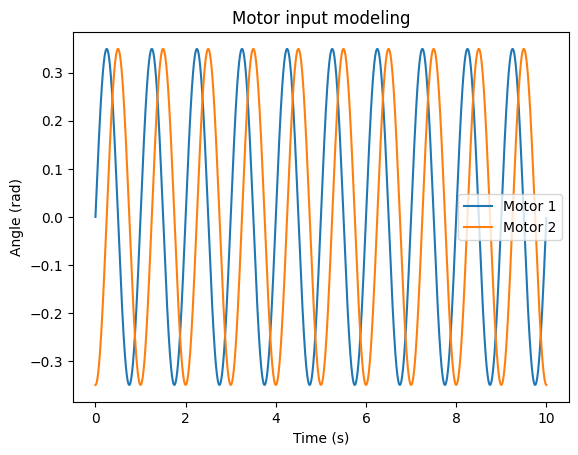

In [5]:
m1 = []
m2 = []
t=[]
for st in range(0,10000,1):
        ts = st/1000
        t.append(ts)
        m1.append(A00*math.sin(2*math.pi*(f*ts-t0_1)))
        m2.append(A11*math.sin(2*math.pi*(f*ts-t0_2)))

plt.plot(t,m1)
plt.plot(t,m2)
plt.xlabel("Time (s)")
plt.ylabel("Angle (rad)")
plt.title("Motor input modeling")
plt.legend(["Motor 1","Motor 2"])

## Static Testing:

1. Robot is suspended at a height where end effector doen't meet the floor to analyze the motion of end effector with walking gait controller

In [6]:
test_type = "static"
#test_type = "dynamic"

if test_type=="static":
    support_height = 0.15
    qpos1 = numpy.array([0.0])

if test_type=="dynamic":
    support_height = 0.1
    qpos1 = numpy.array([-0.2])


qpos2 = numpy.array([90, 90, 60, -90, -90])*math.pi/180
qpos3 = numpy.array([90, 90, 60, -90, -90])*math.pi/180
qpos = numpy.hstack([qpos1,qpos2,qpos3])
support_str = ("0 0 "+(str(support_height)))

In [7]:
#del renderer
xml = xml_template.format(support_pos=support_str,link4=link_str,pos4=pos_str,foot_pos=foot_str)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model,width=800,height=600)
frames,q,xy,t = run_sim(model,data,my_controller,False)

(np.float64(-0.5), np.float64(799.5), np.float64(599.5), np.float64(-0.5))

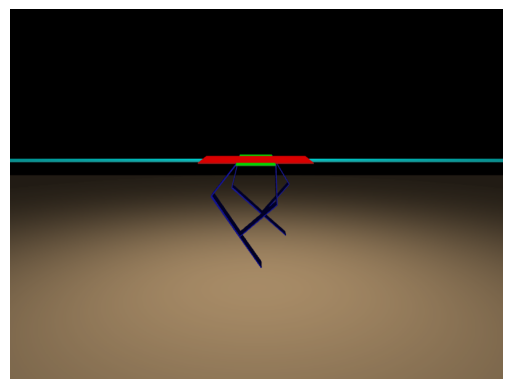

In [8]:
plt.imshow(frames[-200])
plt.axis('off')

In [9]:
media.show_video(frames, fps=framerate, width=800, height=600)

In [10]:
q1 = numpy.array(q)
xy1 = numpy.array(xy)
t1 = numpy.array(t)

Text(0.5, 1.0, 'End Effector Trajectory')

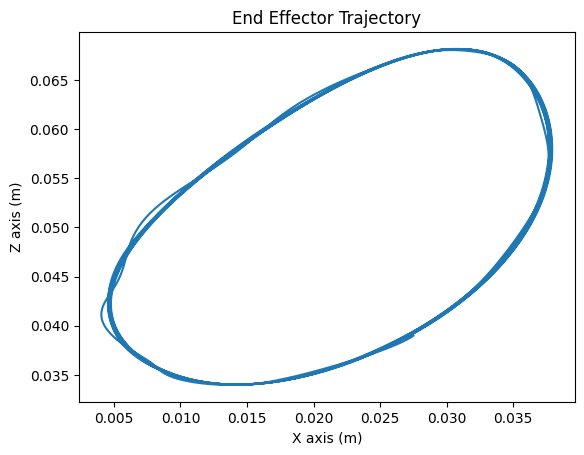

In [11]:
plt.plot(xy1[20000:,10,0],xy1[20000:,10,2])
#plt.plot(xy1[20000:,17,0],xy1[20000:,17,2])
plt.show
plt.xlabel("X axis (m)")
plt.ylabel("Z axis (m)")
plt.title("End Effector Trajectory")

## Dynamic Testing:

1. Robot is suspended at a height where end effector meets the floor to analyze the motion of end effector with walking gait controller

In [12]:
#test_type = "static"
test_type = "dynamic"

if test_type=="static":
    support_height = 0.15
    qpos1 = numpy.array([0.0])

if test_type=="dynamic":
    support_height = 0.1
    qpos1 = numpy.array([-0.2])


qpos2 = numpy.array([90, 90, 60, -90, -90])*math.pi/180
qpos3 = numpy.array([90, 90, 60, -90, -90])*math.pi/180
qpos = numpy.hstack([qpos1,qpos2,qpos3])
support_str = ("0 0 "+(str(support_height)))

In [13]:
del renderer
xml = xml_template.format(support_pos=support_str,link4=link_str,pos4=pos_str,foot_pos=foot_str)
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model,width=800,height=600)
frames,q,xy,t = run_sim(model,data,my_controller,False)

In [14]:
media.show_video(frames, fps=framerate, width=800, height=600)

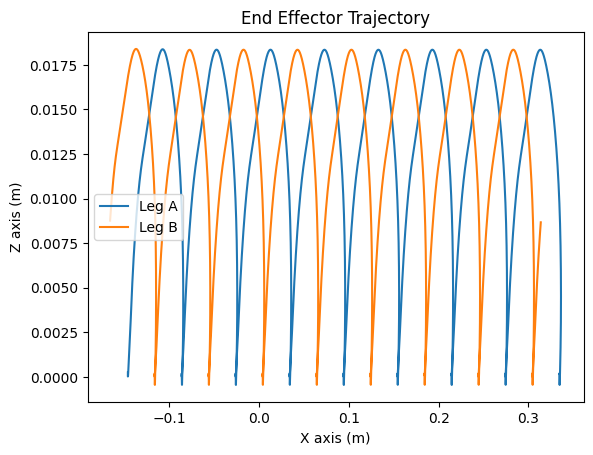

In [16]:
q1 = numpy.array(q)
xy1 = numpy.array(xy)
t1 = numpy.array(t)
plt.plot(xy1[20000:,10,0],xy1[20000:,10,2])
plt.plot(xy1[20000:,17,0],xy1[20000:,17,2])
plt.show
plt.xlabel("X axis (m)")
plt.ylabel("Z axis (m)")
plt.title("End Effector Trajectory")
plt.legend(["Leg A","Leg B"])

#### End effector length optimization

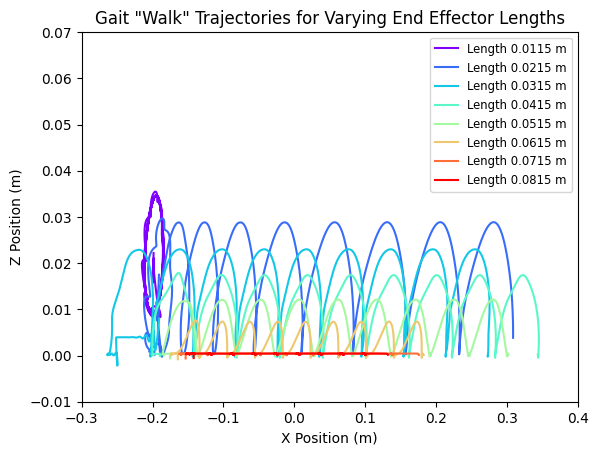

In [23]:
# range of end_effector_length values
start_length = 0.0115
end_length = 0.0815
step = 0.01

colors = cm.rainbow(numpy.linspace(0, 1, int((end_length - start_length) / step) + 1))

distance = []
end_lengths = []
fig, ax = plt.subplots()

for i, eff_length in enumerate(numpy.arange(start_length, end_length + step, step)):
    link_length = (0.05 + eff_length) / 2
    link_str = f"{link_length} 0.01 0.0005"
    pos_str = f"{-1*link_length} 0 0"
    foot_str = f"{-2*link_length} 0 0"
    end_lengths.append(link_length)
    xml = xml_template.format(support_pos=support_str,link4=link_str, pos4=pos_str, foot_pos=foot_str)

    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)

    frames, q, xy, t = run_sim(model, data, my_controller, False)

    xy1 = numpy.array(xy)
    distance.append(xy1[-1, 10, 0])
    ax.plot(xy1[2800:, 10, 0], xy1[2800:, 10, 2], color=colors[i], label=f'Length {eff_length:.4f} m')

ax.set_xlabel('X Position (m)')
ax.set_ylabel('Z Position (m)')
ax.set_title('Gait "Walk" Trajectories for Varying End Effector Lengths')
ax.legend(loc='best', fontsize='small')
ax.set_xlim([-0.3, 0.4])  
ax.set_ylim([-0.01, 0.07])  
plt.show()


In [24]:
# range of end_effector_length values
start_length = 0.0115
end_length = 0.0815
step = 0.002

colors = cm.rainbow(numpy.linspace(0, 1, int((end_length - start_length) / step) + 1))

distance = []
end_lengths = []

for i, eff_length in enumerate(numpy.arange(start_length, end_length + step, step)):
    link_length = (0.05 + eff_length) / 2
    link_str = f"{link_length} 0.01 0.0005"
    pos_str = f"{-1*link_length} 0 0"
    foot_str = f"{-2*link_length} 0 0"
    end_lengths.append(link_length)
    xml = xml_template.format(support_pos=support_str,link4=link_str, pos4=pos_str, foot_pos=foot_str)

    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)

    frames, q, xy, t = run_sim(model, data, my_controller, False)

    xy1 = numpy.array(xy)
    distance.append(xy1[-1, 10, 0])
    


Text(0.5, 1.0, 'Distance travelled by robot in 10 seconds')

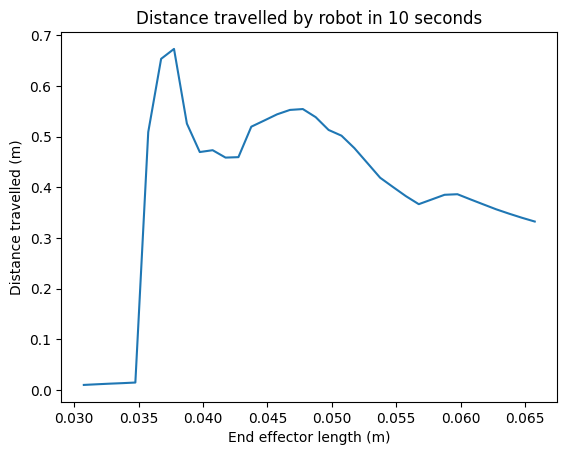

In [32]:
distance_corrected = numpy.array(distance)+0.2
end_lengths_arr = numpy.array(end_lengths)
plt.plot(end_lengths_arr,distance_corrected)
plt.xlabel("End effector length (m)")
plt.ylabel("Distance travelled (m)")
plt.title("Distance travelled by robot in 10 seconds")

Max Distance found with end effector length = 0.03775 m, distance travelled is = 0.67305 m


Text(0.5, 1.0, 'Distance travelled by robot in 10 seconds')

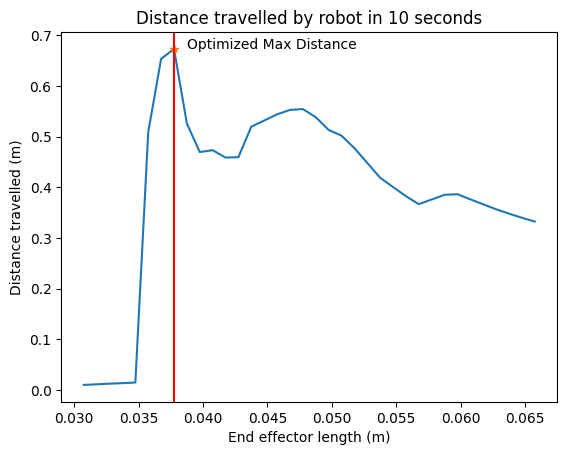

In [39]:
from scipy.optimize import minimize

# Define the objective function for minimization
def objective(x):
    # Ensure x is within the range of end effector lengths
    if x < end_lengths_arr.min() or x > end_lengths_arr.max():
        return float('inf') # Penalize out-of-bound inputs
    # Find the closest end effector value to x and return the corresponding -distance travelled
    idx = numpy.argmin(numpy.abs(end_lengths_arr - x))
    return -distance_corrected[idx] # Negative to maximize distance 

# Perform optimization
result = minimize(objective, x0=end_lengths_arr[numpy.argmax(distance_corrected)], bounds=[(end_lengths_arr.min(),end_lengths_arr.max())])
# Extract the results
end_opt = result.x[0]
idx_opt = numpy.argmin(numpy.abs(end_lengths_arr - end_opt))
dist_opt = distance_corrected[idx_opt]
# Print the results
print(f"Max Distance found with end effector length = {end_opt:.5f} m, distance travelled is = {dist_opt:.5f} m")
plt.plot(end_lengths_arr,distance_corrected)
plt.plot(end_opt,dist_opt,"*")
plt.axvline(x=end_opt,color="red")
plt.text(end_opt+0.001,dist_opt+0.001,"Optimized Max Distance")
plt.xlabel("End effector length (m)")
plt.ylabel("Distance travelled (m)")
plt.title("Distance travelled by robot in 10 seconds")

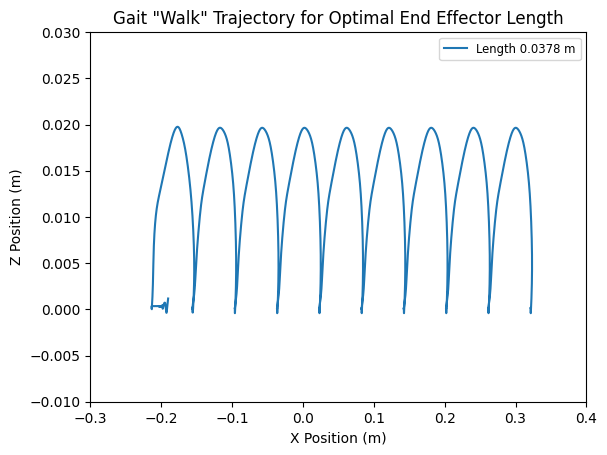

In [43]:
optimised_link_length = (0.05 + end_opt) / 2
link_str = f"{optimised_link_length} 0.01 0.0005"
pos_str = f"{-1*optimised_link_length} 0 0"
foot_str = f"{-2*optimised_link_length} 0 0"

xml = xml_template.format(support_pos=support_str,link4=link_str, pos4=pos_str, foot_pos=foot_str)

model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)

frames, q, xy, t = run_sim(model, data, my_controller, False)
fig_op, optm = plt.subplots()
xy1 = numpy.array(xy)
optm.plot(xy1[2800:, 10, 0], xy1[2800:, 10, 2], label=f'Length {end_opt:.4f} m')

optm.set_xlabel('X Position (m)')
optm.set_ylabel('Z Position (m)')
optm.set_title('Gait "Walk" Trajectory for Optimal End Effector Length')
optm.legend(loc='best', fontsize='small')
optm.set_xlim([-0.3, 0.4])  
optm.set_ylim([-0.01, 0.03])  
plt.show()

In [44]:
media.show_video(frames, fps=framerate, width=800, height=600)